step 1: elapsed 0.7892320156097412
step 2: elapsed 0.004903316497802734
step 3: elapsed 0.009407997131347656
step 4: elapsed 0.35514354705810547
step 5: elapsed 0.002274036407470703
step 5: elapsed 0.002573251724243164
elapsed 1.164768934249878


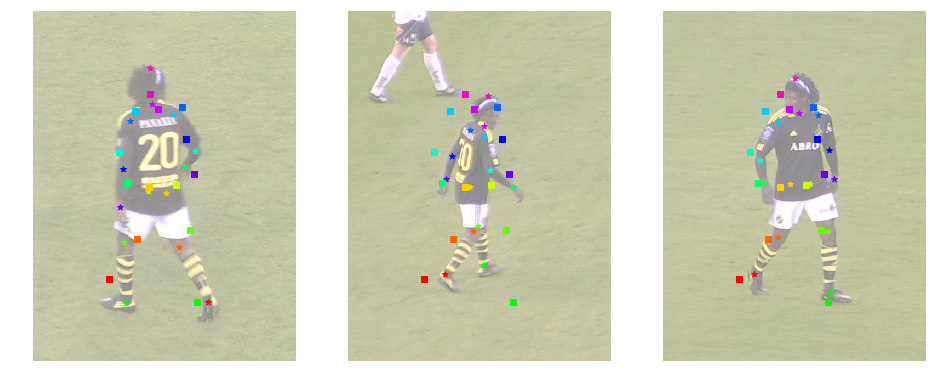

In [30]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader

from mvpose.algorithm import settings

params = settings.get_settings(scale_to_mm=1000)

colors = cs.lincolor(16).astype('float32')/255
FRAME = 0
data_root = Settings['data_root']
seq1_zipname = 'player1sequence1.zip'
seq1_dir = 'Sequence 1'
Im, Calib, pos2d, pos3d = kth.get(data_root, seq1_zipname, seq1_dir, FRAME)


from mvpose.algorithm.candidate_selection import project_human_to_2d

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME)
_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = kth.transform3d_from_mscoco(detections)

fig = plt.figure(figsize=(16,10))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid], marker='*')

    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for jid, p in enumerate(human2d):
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[jid], marker='s')

plt.show()

In [33]:
from mvpose.evaluation import pcp

r = pcp.evaluate(pos3d, Humans[0], 0.5)

print('lower_arms\t', r.lower_arms)
print('upper_arms\t', r.upper_arms)
print('lower_legs\t', r.lower_legs)
print('upper_legs\t', r.upper_legs)
print('pelvis\t\t', r.pelvis)
print('shoulder\t', r.shoulder)
print('head\t\t', r.head)
print('all_parts\t', r.all_parts)

lower_arms	 1.0
upper_arms	 1.0
lower_legs	 1.0
upper_legs	 1.0
pelvis		 1.0
shoulder	 1.0
head		 0
all_parts	 1.0
